# Trial Run: Right-handed fastballs (2023 for now)

In [1]:
#Trial run: using Kmeans to look at groups of righthanded fastballs 
#Only going to use 3 features to start: velocity
#Then going to add on a 4th: VAA (calculatable from statcast)

## Using pybaseball to get statcast pitch metrics

In [1]:
import pybaseball
import pandas as pd
import numpy as np

In [15]:
from pybaseball import statcast_pitcher
from pybaseball import statcast
start_date = '2023-03-30' #opening day 2023
end_date = '2023-10-01' #last day of regular season in 2023
statcast = statcast(start_date, end_date)

This is a large query, it may take a moment to complete


C:\Users\Sean Salvador\anaconda3\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [01:50<00:00,  1.68it/s]


## Data Validation, Cleaning for Statcast Data

Link to statcast documentation: https://baseballsavant.mlb.com/csv-docs

In [139]:
#Narrow down columns
p_features = ['player_name', 'pitcher', 'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'p_throws',
             'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed',
              'release_spin_rate', 'release_extension']
statcast_df = statcast.loc[:, p_features] #select all rows, only columns above

In [140]:
statcast_df.columns

Index(['player_name', 'pitcher', 'pitch_type', 'release_speed',
       'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'effective_speed', 'release_spin_rate', 'release_extension'],
      dtype='object')

In [141]:
# Check for missing values in the entire DataFrame
has_missing_values = statcast_df.isnull().any(axis=1) #looking at each row 

if has_missing_values.all():
    print('Table has no missing values')
else:
    print('Missing value(s) detected')

# If you want to get the indices of rows with no missing values
rows_with_missing_values = statcast_df[has_missing_values].index.tolist()
len(rows_with_missing_values), len(statcast_df)

Missing value(s) detected


(4770, 717709)

In [142]:
#look at rows with missing values
statcast_df[statcast_df.isnull().any(axis=1)].head(3)#note that only missing values are from spin_rate and release_extension

,player_name,pitcher,pitch_type,release_speed,release_pos_x,release_pos_z,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension
2662,"Duffey, Tyler",608648,SL,82.8,-2.88,5.59,R,1.16,-0.19,1.31,2.02,7.294406,-120.395029,-1.215412,9.675326,25.512156,-33.994416,0.0,<NA>,<NA>
2740,"Giolito, Lucas",608337,CH,80.5,-1.69,6.29,R,-0.73,1.02,-1.13,3.97,2.638708,-117.27792,-0.436274,-7.27992,21.356307,-22.901762,0.0,<NA>,<NA>
319,"Parsons, Wes",641149,FF,94.4,-1.72,5.64,R,-0.71,1.41,0.36,3.0,7.014451,-137.22845,-4.32304,-10.58148,31.68832,-13.594461,94.8,<NA>,6.7


In [143]:
#drop rows with missing values 
statcast_df.dropna(axis = 0, how = 'any', inplace = True)
len(statcast_df) #note that df became shorter

712939

In [144]:
#Make sure data types are correct 
statcast_df.dtypes

player_name           object
pitcher                Int64
pitch_type            object
release_speed        Float64
release_pos_x        Float64
release_pos_z        Float64
p_throws              object
pfx_x                Float64
pfx_z                Float64
plate_x              Float64
plate_z              Float64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
effective_speed      Float64
release_spin_rate      Int64
release_extension    Float64
dtype: object

In [145]:
statcast_df.head(3)

,player_name,pitcher,pitch_type,release_speed,release_pos_x,release_pos_z,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension
2391,"Robertson, Nick",687798,CH,89.0,-2.8,5.59,R,-1.53,0.33,0.33,2.01,11.122985,-129.176025,-3.49208,-19.471845,26.055263,-27.922064,90.7,1703,7.4
2535,"Robertson, Nick",687798,FF,96.9,-2.4,5.9,R,-0.76,1.36,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434,98.4,2153,7.4
2617,"Robertson, Nick",687798,CH,90.0,-2.93,5.56,R,-1.65,0.36,-0.24,0.53,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717,91.5,1698,7.4


In [146]:
# Convert 'p_throws' from Righty and Lefty to binary, 0 = R, 1 = L
right_or_left_dict = {'R': 0, 'L': 1}
statcast_df['p_throws'] = statcast_df['p_throws'].map(right_or_left_dict)

#Convert player_name from 'Last_name, First_name' to 'First_name + Last_name'
def first_last(last_first): #last_first is a string
    last, first = last_first.split(',')
    name = (first +  ' ' + last)
    name = name.strip()
    return name 
statcast_df['player_name'] = statcast_df['player_name'].apply(first_last)

# Rescale horizontal and vertical movement from ft to inches
statcast_df['pfx_x'] = statcast_df['pfx_x'] * 12
statcast_df['pfx_z'] = statcast_df['pfx_z']  * 12

# Rescale horizontal so that positive is armside, negative is gloveside
# Default is from catcher's perspective, so lefty stays the same (lefty armside movement = catcher moving in positive x)
# So only change right-handed horizontal
right = statcast_df[statcast_df['p_throws'] == 0]
right.loc[:, 'pfx_x'] = right.loc[:, 'pfx_x'] * -1

# Update the original DataFrame with the modified values
statcast_df.loc[statcast_df['p_throws'] == 0, 'pfx_x'] = right['pfx_x']
statcast_df

,player_name,pitcher,pitch_type,release_speed,release_pos_x,release_pos_z,p_throws,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension
2391,Nick Robertson,687798,CH,89.0,-2.8,5.59,0,18.36,3.96,0.33,2.01,11.122985,-129.176025,-3.49208,-19.471845,26.055263,-27.922064,90.7,1703,7.4
2535,Nick Robertson,687798,FF,96.9,-2.4,5.9,0,9.12,16.32,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434,98.4,2153,7.4
2617,Nick Robertson,687798,CH,90.0,-2.93,5.56,0,19.8,4.32,-0.24,0.53,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717,91.5,1698,7.4
2680,Nick Robertson,687798,SL,82.2,-3.09,5.55,0,-17.16,3.36,0.81,0.49,6.108013,-119.483805,-5.435467,12.155221,26.646301,-28.491928,82.4,2786,6.9
2804,Nick Robertson,687798,CH,89.2,-2.87,5.58,0,17.88,3.72,-0.78,2.05,8.417443,-129.604641,-3.33637,-18.554455,27.650862,-28.148796,90.5,1589,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,Luis Castillo,622491,SI,95.3,-3.11,5.24,0,20.28,5.52,-0.99,2.71,9.201895,-138.423082,-1.991621,-23.770343,31.916125,-25.980264,93.8,2120,5.6
4088,Luis Castillo,622491,FF,94.2,-3.16,5.29,0,15.36,13.92,-0.73,2.89,9.000928,-136.91071,-3.03337,-18.146418,31.14284,-17.179404,92.7,2284,5.6
4173,Luis Castillo,622491,FF,94.8,-3.12,5.3,0,9.6,14.28,1.6,2.42,13.806743,-137.289614,-4.379497,-13.21554,30.656157,-16.257589,92.8,2122,5.4
4301,Luis Castillo,622491,SI,95.1,-3.2,5.22,0,20.52,4.92,-1.31,2.23,8.631623,-138.21843,-3.042235,-23.838213,32.42909,-26.362125,93.5,2126,5.5


In [147]:
# Rename columns for readability purposes 
rename_columns = {
    'release_speed': 'velo',
    'release_pos_x': 'h_release_pt',
    'release_pos_z': 'v_release_pt',  
    'pfx_x': 'h_mvmt_in',
    'pfx_z': 'v_mvmt_in',
    'release_extension': 'extension',
}

statcast_df = statcast_df.rename(columns=rename_columns) 
statcast_df

,player_name,pitcher,pitch_type,velo,h_release_pt,v_release_pt,p_throws,h_mvmt_in,v_mvmt_in,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,extension
2391,Nick Robertson,687798,CH,89.0,-2.8,5.59,0,18.36,3.96,0.33,2.01,11.122985,-129.176025,-3.49208,-19.471845,26.055263,-27.922064,90.7,1703,7.4
2535,Nick Robertson,687798,FF,96.9,-2.4,5.9,0,9.12,16.32,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434,98.4,2153,7.4
2617,Nick Robertson,687798,CH,90.0,-2.93,5.56,0,19.8,4.32,-0.24,0.53,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717,91.5,1698,7.4
2680,Nick Robertson,687798,SL,82.2,-3.09,5.55,0,-17.16,3.36,0.81,0.49,6.108013,-119.483805,-5.435467,12.155221,26.646301,-28.491928,82.4,2786,6.9
2804,Nick Robertson,687798,CH,89.2,-2.87,5.58,0,17.88,3.72,-0.78,2.05,8.417443,-129.604641,-3.33637,-18.554455,27.650862,-28.148796,90.5,1589,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,Luis Castillo,622491,SI,95.3,-3.11,5.24,0,20.28,5.52,-0.99,2.71,9.201895,-138.423082,-1.991621,-23.770343,31.916125,-25.980264,93.8,2120,5.6
4088,Luis Castillo,622491,FF,94.2,-3.16,5.29,0,15.36,13.92,-0.73,2.89,9.000928,-136.91071,-3.03337,-18.146418,31.14284,-17.179404,92.7,2284,5.6
4173,Luis Castillo,622491,FF,94.8,-3.12,5.3,0,9.6,14.28,1.6,2.42,13.806743,-137.289614,-4.379497,-13.21554,30.656157,-16.257589,92.8,2122,5.4
4301,Luis Castillo,622491,SI,95.1,-3.2,5.22,0,20.52,4.92,-1.31,2.23,8.631623,-138.21843,-3.042235,-23.838213,32.42909,-26.362125,93.5,2126,5.5


In [148]:
#Reorder columns so most important metrics are to the left
new_order = ['player_name', 'pitcher', 'p_throws', 'pitch_type', 'velo', 'h_mvmt_in', 'v_mvmt_in', 'extension',
            'h_release_pt', 'v_release_pt', 'effective_speed', 'release_spin_rate', 
             'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']
statcast_df = statcast_df[new_order]
statcast_df

,player_name,pitcher,p_throws,pitch_type,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,v_release_pt,effective_speed,release_spin_rate,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
2391,Nick Robertson,687798,0,CH,89.0,18.36,3.96,7.4,-2.8,5.59,90.7,1703,0.33,2.01,11.122985,-129.176025,-3.49208,-19.471845,26.055263,-27.922064
2535,Nick Robertson,687798,0,FF,96.9,9.12,16.32,7.4,-2.4,5.9,98.4,2153,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434
2617,Nick Robertson,687798,0,CH,90.0,19.8,4.32,7.4,-2.93,5.56,91.5,1698,-0.24,0.53,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717
2680,Nick Robertson,687798,0,SL,82.2,-17.16,3.36,6.9,-3.09,5.55,82.4,2786,0.81,0.49,6.108013,-119.483805,-5.435467,12.155221,26.646301,-28.491928
2804,Nick Robertson,687798,0,CH,89.2,17.88,3.72,7.2,-2.87,5.58,90.5,1589,-0.78,2.05,8.417443,-129.604641,-3.33637,-18.554455,27.650862,-28.148796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,Luis Castillo,622491,0,SI,95.3,20.28,5.52,5.6,-3.11,5.24,93.8,2120,-0.99,2.71,9.201895,-138.423082,-1.991621,-23.770343,31.916125,-25.980264
4088,Luis Castillo,622491,0,FF,94.2,15.36,13.92,5.6,-3.16,5.29,92.7,2284,-0.73,2.89,9.000928,-136.91071,-3.03337,-18.146418,31.14284,-17.179404
4173,Luis Castillo,622491,0,FF,94.8,9.6,14.28,5.4,-3.12,5.3,92.8,2122,1.6,2.42,13.806743,-137.289614,-4.379497,-13.21554,30.656157,-16.257589
4301,Luis Castillo,622491,0,SI,95.1,20.52,4.92,5.5,-3.2,5.22,93.5,2126,-1.31,2.23,8.631623,-138.21843,-3.042235,-23.838213,32.42909,-26.362125


In [149]:
#Check types only player_name, pitch_type should be object
statcast_df.dtypes

player_name           object
pitcher                Int64
p_throws               int64
pitch_type            object
velo                 Float64
h_mvmt_in            Float64
v_mvmt_in            Float64
extension            Float64
h_release_pt         Float64
v_release_pt         Float64
effective_speed      Float64
release_spin_rate      Int64
plate_x              Float64
plate_z              Float64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
dtype: object

In [150]:
#export cleaned statcast data for 2023 as csv
statcast_df.to_csv('statcast_2023_pybaseball.csv')

## Import Data Here to save search time

In [3]:
import pybaseball
import pandas as pd
import numpy as np

#import it here, can skip above steps
statcast_df = pd.read_csv('statcast_2023_pybaseball.csv')
statcast_df.drop('Unnamed: 0', axis = 1, inplace = True) #drop unnecessary column


In [4]:
statcast_df.head(3)

,player_name,pitcher,p_throws,pitch_type,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,v_release_pt,effective_speed,release_spin_rate,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,Nick Robertson,687798,0,CH,89.0,18.36,3.96,7.4,-2.80,5.59,90.7,1703,0.33,2.01,11.122985,-129.176025,-3.492080,-19.471845,26.055263,-27.922064
1,Nick Robertson,687798,0,FF,96.9,9.12,16.32,7.4,-2.40,5.90,98.4,2153,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434
2,Nick Robertson,687798,0,CH,90.0,19.80,4.32,7.4,-2.93,5.56,91.5,1698,-0.24,0.53,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717


## Using statcast data, make new df with only 4-seam Fastballs

In [5]:
#Narrow down to only FF (Four seam fastball)
ff_df = statcast_df[statcast_df['pitch_type'] == 'FF']
ff_df.head(3)

,player_name,pitcher,p_throws,pitch_type,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,v_release_pt,effective_speed,release_spin_rate,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
1,Nick Robertson,687798,0,FF,96.9,9.12,16.32,7.4,-2.40,5.90,98.4,2153,0.09,2.71,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434
5,Nick Robertson,687798,0,FF,96.2,8.52,16.80,7.3,-2.37,5.96,97.4,2213,0.59,3.56,9.626067,-139.750857,-3.982147,-11.630817,33.893158,-13.112827
7,Nick Robertson,687798,0,FF,95.7,5.76,15.60,7.4,-2.40,5.80,97.5,2097,0.50,2.09,8.916990,-138.968451,-7.230250,-8.153688,30.274685,-13.803886


In [6]:
#Use groupby to get season-long average of all the metrics, also find the count (how many times a pitcher threw FF in 2023)
metrics_to_avg_dict = {
    'pitch_type': 'count', #count how many of the pitch is thrown
    'p_throws': 'mean', #take average for numerical measurements to get season long average
    'velo': 'mean', 
    'h_mvmt_in': 'mean',
    'v_mvmt_in': 'mean', 
    'extension' : 'mean', 
    'h_release_pt' : 'mean', 
    'v_release_pt' : 'mean',
    'effective_speed' : 'mean', 
    'release_spin_rate' : 'mean', 
    'plate_x': 'mean',
    'plate_z': 'mean', 
    'vx0': 'mean',
    'vy0': 'mean', 
    'vz0': 'mean', 
    'ax': 'mean', 
    'ay': 'mean', 
    'az': 'mean'}
#Group by pitcher, aggregate by average of everything
ff_df = ff_df.groupby(['player_name', 'pitcher']).agg(metrics_to_avg_dict).reset_index()
ff_df['p_throws'] = ff_df['p_throws'].round(0)
ff_df.rename(columns = {'pitch_type': 'pitch_count'}, inplace = True) #adjust column name
ff_data = np.full(ff_df.shape[0], 'FF') #insert pitch type col, dissapeared during groupby 
ff_df.insert(2, 'pitch', ff_data)

In [7]:
ff_df.head()

,player_name,pitcher,pitch,pitch_count,p_throws,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,...,effective_speed,release_spin_rate,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
0,A.J. Minter,621345,FF,496,1.0,95.842339,6.509758,16.696694,6.382661,2.383468,...,96.089718,2426.038306,-0.002258,2.818206,-7.533484,-139.344231,-5.407420,8.711267,29.974643,-12.989009
1,A.J. Puk,640462,FF,485,1.0,95.845567,12.049979,12.917691,7.177526,3.458309,...,97.040619,2191.092784,0.032557,2.548887,-11.484241,-139.046521,-4.184430,15.642521,31.804403,-17.418972
2,AJ Smith-Shawver,700363,FF,245,0.0,94.460408,6.596082,17.712000,6.541633,-1.364163,...,95.009796,2194.297959,-0.124327,2.590122,4.476124,-137.388851,-7.214502,-7.918840,29.207253,-12.061710
3,Aaron Bummer,607481,FF,61,1.0,94.683607,11.118689,11.370492,6.586885,2.299836,...,95.275410,2353.278689,-0.190656,2.427213,-8.608731,-137.652994,-3.485566,13.669258,29.329096,-19.509153
4,Aaron Civale,650644,FF,245,0.0,91.832653,4.988571,18.338449,5.682041,-0.504857,...,90.822857,2384.134694,-0.001755,3.220939,2.144761,-133.659837,-5.290400,-5.441532,29.108796,-12.933407


In [8]:
ff_df[ff_df['player_name'] == 'Jacob deGrom']

,player_name,pitcher,pitch,pitch_count,p_throws,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,...,effective_speed,release_spin_rate,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az
305,Jacob deGrom,594798,FF,235,0.0,98.711915,8.694638,17.553702,6.80383,-1.482681,...,99.417872,2550.029787,-0.096596,2.891489,5.514673,-143.551151,-5.383147,-11.306657,34.614563,-10.91361


## Merge Season Statistics (xba, xwoba etc.) onto DataFrames

In [9]:
#imported csv from statcast 
expected_stats = pd.read_csv('expected_stats.csv')
expected_stats.head(3)

,"last_name, first_name",player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff
0,"Mikolas, Miles",571945,2023,860,674,0.282,0.289,-0.007,0.454,0.495,-0.041,0.330,0.353,-0.023,4.78,5.37,-0.587
1,"Webb, Logan",657277,2023,850,619,0.248,0.253,-0.005,0.374,0.392,-0.018,0.283,0.296,-0.013,3.25,3.63,-0.380
2,"Gallen, Zac",668678,2023,846,574,0.238,0.253,-0.015,0.382,0.426,-0.044,0.289,0.315,-0.026,3.47,4.16,-0.689


In [10]:
#Trim down to only desired statistics (mostly the expected statistics)
my_columns = ['last_name, first_name', 'player_id', 'est_ba', 'est_slg', 'woba', 'est_woba', 'xera']
expected_stats = expected_stats[my_columns]

#rename to convention so that 'expected_stat' = 'xstat'
x_columns = {'est_ba': 'xba', 'est_slg': 'xslg', 'est_woba': 'xwoba'}
expected_stats.rename(columns = x_columns, inplace=True)
expected_stats.head()

,"last_name, first_name",player_id,xba,xslg,woba,xwoba,xera
0,"Mikolas, Miles",571945,0.289,0.495,0.330,0.353,5.37
1,"Webb, Logan",657277,0.253,0.392,0.283,0.296,3.63
2,"Gallen, Zac",668678,0.253,0.426,0.289,0.315,4.16
3,"Bassitt, Chris",605135,0.241,0.402,0.304,0.310,4.01
4,"Keller, Mitch",656605,0.250,0.400,0.310,0.314,4.13


In [11]:
#Merge expected stats with dfs
#Use inner join meaning key must show up in both dataframes to appear in merged df
full_stats_df = statcast_df.merge(expected_stats, how = 'inner', left_on = 'pitcher', right_on = 'player_id') #for every pitch
fastball_df = ff_df.merge(expected_stats, how = 'inner', left_on = 'pitcher', right_on = 'player_id') #for fastball df
fastball_df.drop(columns =  ['last_name, first_name', 'player_id'], inplace = True)
fastball_df.head(3)

,player_name,pitcher,pitch,pitch_count,p_throws,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,...,vy0,vz0,ax,ay,az,xba,xslg,woba,xwoba,xera
0,A.J. Minter,621345,FF,496,1.0,95.842339,6.509758,16.696694,6.382661,2.383468,...,-139.344231,-5.407420,8.711267,29.974643,-12.989009,0.218,0.360,0.283,0.284,3.33
1,A.J. Puk,640462,FF,485,1.0,95.845567,12.049979,12.917691,7.177526,3.458309,...,-139.046521,-4.184430,15.642521,31.804403,-17.418972,0.207,0.368,0.300,0.271,3.02
2,AJ Smith-Shawver,700363,FF,245,0.0,94.460408,6.596082,17.712000,6.541633,-1.364163,...,-137.388851,-7.214502,-7.918840,29.207253,-12.061710,0.207,0.392,0.301,0.304,3.85


In [12]:
fastball_df[fastball_df['velo'] == fastball_df['velo'].max()]

,player_name,pitcher,pitch,pitch_count,p_throws,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,...,vy0,vz0,ax,ay,az,xba,xslg,woba,xwoba,xera
336,Jhoan Duran,661395,FF,457,0.0,101.804595,10.719125,13.73488,6.539168,-2.090416,...,-147.973532,-6.021433,-15.033275,34.317726,-14.087863,0.185,0.291,0.271,0.253,2.63


## Performing k-means clustering on 
### Right-handed Pitchers First

In [13]:
#Filter df so only people that threw at least 50 four-seam fastballs are listed
#filter out guys who don't throw 4-seams and position players
#filter to only get rightys 
r_fast_df = fastball_df[(fastball_df['pitch_count'] >= 50) & (fastball_df['p_throws'] == 0)]
r_fast_df 

,player_name,pitcher,pitch,pitch_count,p_throws,velo,h_mvmt_in,v_mvmt_in,extension,h_release_pt,...,vy0,vz0,ax,ay,az,xba,xslg,woba,xwoba,xera
2,AJ Smith-Shawver,700363,FF,245,0.0,94.460408,6.596082,17.712000,6.541633,-1.364163,...,-137.388851,-7.214502,-7.918840,29.207253,-12.061710,0.207,0.392,0.301,0.304,3.85
4,Aaron Civale,650644,FF,245,0.0,91.832653,4.988571,18.338449,5.682041,-0.504857,...,-133.659837,-5.290400,-5.441532,29.108796,-12.933407,0.243,0.378,0.288,0.298,3.69
6,Aaron Nola,605400,FF,904,0.0,92.716814,12.189027,15.139513,6.897677,-1.994679,...,-134.798812,-3.205596,-14.018210,29.593155,-16.287422,0.241,0.407,0.303,0.300,3.74
8,Adam Cimber,643256,FF,151,0.0,85.258278,11.208477,4.821457,6.615232,-4.135828,...,-123.435563,7.656625,-11.629484,23.845618,-29.905922,0.291,0.470,0.393,0.371,6.04
9,Adam Oller,670124,FF,186,0.0,93.687634,9.423226,18.194839,6.334409,-1.718871,...,-136.187576,-4.880885,-11.299074,30.497781,-12.423340,0.312,0.549,0.417,0.409,7.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,Zack Greinke,425844,FF,587,0.0,89.546508,2.862624,15.742487,6.017036,-1.297871,...,-130.336146,-5.864425,-3.421719,25.761384,-16.188373,0.287,0.475,0.332,0.343,5.03
731,Zack Kelly,677161,FF,79,0.0,94.562025,11.592911,15.669873,6.896203,-2.976962,...,-137.257867,-4.784977,-14.337905,33.113430,-14.805325,0.227,0.390,0.357,0.368,5.92
732,Zack Littell,641793,FF,413,0.0,94.084262,8.318063,17.351477,6.346489,-0.990799,...,-136.887851,-5.429839,-9.573148,30.637761,-13.007007,0.270,0.429,0.308,0.315,4.16
734,Zack Weiss,592848,FF,65,0.0,94.063077,4.523077,18.299077,6.395385,-1.312462,...,-136.832864,-5.495517,-5.658006,30.850565,-12.006685,0.238,0.428,0.305,0.328,4.55


In [14]:
r_fast_df.columns

Index(['player_name', 'pitcher', 'pitch', 'pitch_count', 'p_throws', 'velo',
       'h_mvmt_in', 'v_mvmt_in', 'extension', 'h_release_pt', 'v_release_pt',
       'effective_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'xba', 'xslg', 'woba', 'xwoba', 'xera'],
      dtype='object')

## Feature Selection and Data Normalization

In [15]:
#Feature selection method: Using correlation to pick features, comparing to xwOBA 
correlations = []
for i in r_fast_df.columns[5:13]: #from velo to spin rate
    r_value = r_fast_df.loc[:, i].corr(r_fast_df.loc[:, 'xwoba']) #go through the desired features and find corr to xwoBA
    correlations.append((abs(r_value), i)) 

#use values to make a df 
df_corr = pd.DataFrame(correlations, columns = ['r', 'Column']).sort_values(by = 'r', ascending=False)
df_corr

,r,Column
6,0.328333,effective_speed
0,0.295428,velo
7,0.234399,release_spin_rate
3,0.194522,extension
2,0.086906,v_mvmt_in
5,0.036617,v_release_pt
4,0.014918,h_release_pt
1,0.001623,h_mvmt_in


In [ ]:
#Feature Selection = 3, Data Normalization

#First start with 3 features - the big 3 (velo, horizontal, vertical)
features = ['velo', 'h_mvmt_in', 'v_mvmt_in']
r_fastball_3 = r_fast_df[features].reset_index(drop=True)

#normalize data using standardization (each feature has mean of 0, standard deviation of 1)
#using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler
# Assuming X is your data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(r_fastball_3)
right_ff_df = pd.DataFrame(standardized_data, columns = features) #convert back to df
right_ff_df.head(3)

## Creating k-means function 

In [109]:
import sklearn
import scipy
from scipy.cluster.vq import kmeans2
from sklearn.metrics import silhouette_score

#function that stores each cluster and the indexes of the points in the cluster
def cluster_indexes(labels): #uses labels from kmeans
    cluster_dict = {}
    for i, label in enumerate(labels):
        if label not in cluster_dict:
            cluster_dict[label] = [i]
        else:
            cluster_dict[label].append(i)
    return cluster_dict
            
#function that calculates inertia of clustering
#inertia = sum of squared errors: quantifies the compactness or tightness of clusters in a dataset
def clustering_inertia(pitch_df, cluster_dict, k_centroids):
    #cluster_dict = dictionary from cluster_indexes(), centroids = from kmeans(), pitch_df = df used in kmeans
    inertia = 0
    for i in cluster_dict.keys(): #go through each cluster
        sum_squared_error = 0
        for j in cluster_dict[i]: #go through each point in the cluster, calculate sum of squared errors
            centroid_loc = k_centroids[i]
            x_error = right_ff_df.iloc[j][0] - centroid_loc[0] #difference in x direction
            y_error = right_ff_df.iloc[j][1] - centroid_loc[1] #difference in y direction
            z_error = right_ff_df.iloc[j][2] - centroid_loc[2] #difference in z direction
            sum_squared_error += (x_error)**2 + (y_error)**2 + (z_error)**2
        inertia += sum_squared_error
    return inertia

#function that calculates silhoutte score of clustering
def clustering_silhouette_score(pitch_df, labels):
    sc = silhouette_score(pitch_df, labels, metric = 'euclidean')
    return sc
clustering_silhouette_score(right_ff_df, labels)


0.2369003487985144

In [111]:
#Culminating function that uses functions above:
def pitch_kmeans(pitch_df, k_count, iter_count): 
    #df should be normalized, k_count = number of clusters, iter_count = number of iterations
    #run kmeans test to find k clusters for points in training dataset
    #using ++ version of kmeans, which results in better starting centroids
    k_centroids, labels = kmeans2(pitch_df, k=k_count, iter=iter_count, minit='++')
    cluster_dict = cluster_indexes(labels)
    inertia = clustering_inertia(pitch_df, cluster_dict, k_centroids)
    silhouette_score = clustering_silhouette_score(pitch_df, labels)
    return inertia, silhouette_score, k_centroids


## Fine-tuning Hyperparameters
### Using inertia and silhouette score to find best k 

In [120]:
results = pitch_kmeans(right_ff_df, k_count, 300)
results

(545.0104423300518,
 0.22642798486633647,
 array([[ 1.06687597,  0.9069293 , -0.51511665],
        [ 0.44165869,  0.05002068,  0.61646378],
        [-0.91786563, -1.25015509, -1.56847395],
        [-0.77807824,  0.76842415, -0.51908412],
        [-0.36905713, -1.02912968,  0.7495944 ]]))

In [122]:
#Using for loop to calculate inertia and silhouette score for many k
#Store results in list:
k_inertia_silscore_centroids = []
for k in range(2,51): #try k ranging from 3 to 50
    k_count = k
    iter_count = 300
    results = pitch_kmeans(right_ff_df, k_count, iter_count)
    inertia = results[0] 
    sil_score = results[1]
    centroids = results[2]
    k_inertia_silscore_centroids.append((k_count, inertia, sil_score))
    
k_inertia_silscore_centroids

[(2, 948.756209445279, 0.24677098080385385),
 (3, 748.8270790930679, 0.24767770679536322),
 (4, 640.2699203655162, 0.21282538840704585),
 (5, 578.9230155353455, 0.2558870968924105),
 (6, 476.16275861580567, 0.23607451180504516),
 (7, 439.3910343822695, 0.23576163000824885),
 (8, 413.42222121273437, 0.23707025268388648),
 (9, 383.640902077963, 0.22688328241360822),
 (10, 353.79823047623074, 0.2347759136517516),
 (11, 340.5184526661471, 0.21468148424553457),
 (12, 321.33815216790816, 0.23258240406120523),
 (13, 292.3606076055912, 0.23922463119790854),
 (14, 276.6339602908476, 0.24147500294179933),
 (15, 265.2287648585696, 0.22842317553326613),
 (16, 271.4169527620804, 0.22269898788369358),
 (17, 247.87204371071138, 0.23037136888974508),
 (18, 245.75021187238096, 0.20881183459398606),
 (19, 215.90615700358583, 0.24858274259573404),
 (20, 213.21507583195836, 0.24860471435639456),
 (21, 216.02990199279432, 0.23484373580761045),
 (22, 208.23900285957146, 0.22467255490976412),
 (23, 193.70034

In [ ]:
#Store results in lists, used for visualization later
k_vs_inertia = [] 
k_vs_silhoutte = [] 

In [106]:
#Performing kmeans using scipy 
#Function performs kmeans clustering
#returns inertia, silhoutte score, locations of centroids
from scipy.cluster.vq import kmeans2
from sklearn.metrics import silhouette_score 

def pitch_kmeans(pitch_df, k_count, iter_count): 
    #df should be normalized, k_count = number of clusters, iter_count = number of iterations
    #run kmeans test to find k clusters for points in training dataset
    #using ++ version of kmeans, which results in better starting centroids
    k_centroids, labels = kmeans2(pitch_df, k=k_count, iter=iter_count, minit='++')
    cluster_dict = cluster_indexes(labels)
    inertia = clustering_inertia(pitch_df, cluster_dict, k_centroids)
    silhouette_score = clustering_silhouette_score(pitch_df, labels)
    return inertia, k_centroids, silhouette_score
    
results = pitch_kmeans(right_ff_df, k_count, iter_count)


0.229642171851095

In [16]:
#Feature Selection = 3, Data Normalization

#First start with 3 features - the big 3 (velo, horizontal, vertical)
features = ['velo', 'h_mvmt_in', 'v_mvmt_in']
r_fastball_3 = r_fast_df[features].reset_index(drop=True)

#normalize data using standardization (each feature has mean of 0, standard deviation of 1)
#using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler
# Assuming X is your data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(r_fastball_3)
right_ff_df = pd.DataFrame(standardized_data, columns = features) #convert back to df
right_ff_df.head(3)

,velo,h_mvmt_in,v_mvmt_in
0,0.026222,-0.275308,0.940461
1,-1.150274,-0.797026,1.212939
2,-0.754418,1.539886,-0.178461


## DS 121: Check if points are actually far away (check lecture, iphone notes)
## The Curse of High Dimensionality

## Evaluating Clustering Using Inertia/ Elbow Method (euclidean distances) and Silhoutte Score 
### DS 210 Lesson: MSE vs MAE (MAE ignores outliers more) 
#### In this case: outlier pitchers are important so don't ignore, could also use a loss function like huber loss function


In [ ]:
sum_mse = 
for i in 

## Visualization: all points and best clustering
### maybe - just do in r

In [38]:
#plotly - interactive 3d plots
#NOT STANDARDIZED 
import plotly.express as px

# Get x, y, z from df
z = r_fastball_3['velo']
x = r_fastball_3['h_mvmt_in']
y = r_fastball_3['v_mvmt_in']

# Create an interactive 3D scatter plot using Plotly Express
fig = px.scatter_3d(r_fastball_3, x=x, y=y, z=z,
                    labels={'x': 'Velocity (mph)',
                            'y': 'Horizontal Movement (inches)',
                            'z': 'Vertical Movement (inches)'},
                    title='Right-Handed Fastballs')

fig.update_traces(marker=dict(size=2)) 
fig.update_layout(
    width=1920*2/4,  # Set the width to your screen width or desired width
    height=1080*2/4,  # Set the height to your screen height or desired height
)
# Show the interactive plot
fig.show()


In [48]:
#FANCY STANDARDIZED DATA
import plotly.express as px
import plotly.graph_objects as go

# Get x, y, z from df
z = right_ff_df['velo']
x = right_ff_df['h_mvmt_in']
y = right_ff_df['v_mvmt_in']

# Create an interactive 3D scatter plot using Plotly Express
fig = px.scatter_3d(right_ff_df, x=x, y=y, z=z,
                    labels={'x': 'Velocity (mph)',
                            'y': 'Horizontal Movement (inches)',
                            'z': 'Vertical Movement (inches)'},
                    title='Right-Handed Fastballs')

fig.update_traces(marker=dict(size=2))

# Add centroids as a separate trace
centroid_trace = go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', 
                              marker=dict(size=5, color='red'),
                              name='Centroids')

fig.add_trace(centroid_trace)

fig.update_layout(
    width=1920*2/4,  # Set the width to your screen width or desired width
    height=1080*2/4,  # Set the height to your screen height or desired height
)

# Show the interactive plot
fig.show()


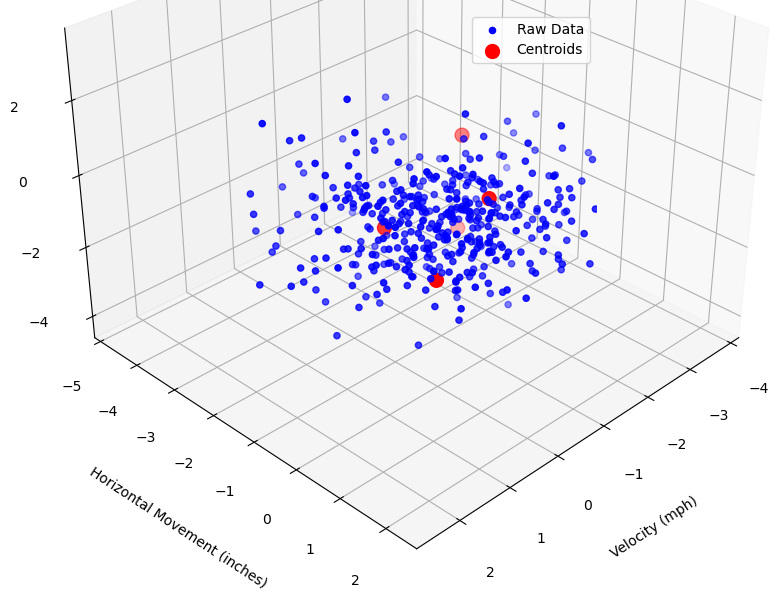

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get x, y, z from the first DataFrame (raw data)
x1 = right_ff_df['velo']
y1 = right_ff_df['h_mvmt_in']
z1 = right_ff_df['v_mvmt_in']

# Get x, y, z from the second DataFrame (centroids)
x2 = horizontal
y2 = vertical
z2 = velo

# Create a 3D scatter plot for the raw data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y1, z1, x1, c='b', marker='o', label='Raw Data')

# Create a 3D scatter plot for the centroids
ax.scatter(y2, z2, x2, c='r', marker='o', s=100, label='Centroids')

# Set labels
ax.set_xlabel('Velocity (mph)')
ax.set_ylabel('Horizontal Movement (inches)')
ax.set_zlabel('Vertical Movement (inches)')

# Adjust viewing
ax.set_box_aspect(None, zoom=2)
ax.view_init(elev=30, azim=45, roll=0)

# Add a legend
ax.legend()

plt.show()


In [ ]:
#Now try adding 4th dimension: VAA
features = 

In [ ]:
#Now add release point statistics: horizontal, vertical, extension
features 